In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold,train_test_split, cross_val_score, GridSearchCV, KFold #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import StandardScaler,OneHotEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay, make_scorer, mean_squared_error,classification_report,confusion_matrix,ConfusionMatrixDisplay, roc_curve, auc,roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.cluster import KMeans


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/mn42899/schulich_data_science/main/Dataset.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Employee ID            10000 non-null  int64  
 1   Age                    10000 non-null  int64  
 2   Gender                 10000 non-null  object 
 3   Job Role               10000 non-null  object 
 4   Department             10000 non-null  object 
 5   Monthly Income         10000 non-null  int64  
 6   Years at Company       10000 non-null  int64  
 7   Number of Promotions   10000 non-null  int64  
 8   Last Raise Percentage  10000 non-null  float64
 9   Distance from Office   10000 non-null  float64
 10  Job Satisfaction       10000 non-null  int64  
 11  Performance Rating     10000 non-null  int64  
 12  Attrition              10000 non-null  object 
dtypes: float64(2), int64(7), object(4)
memory usage: 1015.8+ KB


In [5]:
df.head()

,Employee ID,Age,Gender,Job Role,Department,Monthly Income,Years at Company,Number of Promotions,Last Raise Percentage,Distance from Office,Job Satisfaction,Performance Rating,Attrition
0,1,50,Male,HR,IT,11547,12,1,12.288783,41.307654,9,1,No
1,2,36,Male,Sales,Support,8643,28,4,3.496371,44.733204,8,1,Yes
2,3,29,Male,Technician,HR,12418,12,4,4.796945,18.646876,1,3,No
3,4,42,Male,Technician,Support,11441,25,1,10.310471,15.790848,8,4,No
4,5,40,Female,Engineer,Sales,9178,25,2,6.210127,41.239179,6,4,No


In [6]:
df['Years at Company'].describe()

count    10000.000000
mean        14.311100
std          8.742572
min          0.000000
25%          7.000000
50%         14.000000
75%         22.000000
max         30.000000
Name: Years at Company, dtype: float64

In [7]:
# Define the age bins and labels
bins = [0, 7, 14, 22, float('inf')]
labels = ['0-6', '7-13', '14-21', '22+']

# Create the age bins and label them
df['years_at_comp_bins'] = pd.cut(df['Years at Company'], bins=bins, labels=labels, right=False)

df['years_at_comp_bins'].value_counts()

years_at_comp_bins
22+      2620
14-21    2616
0-6      2432
7-13     2332
Name: count, dtype: int64

In [8]:
df['Age'].describe()

count    10000.000000
mean        40.561200
std         10.876483
min         22.000000
25%         31.000000
50%         41.000000
75%         50.000000
max         59.000000
Name: Age, dtype: float64

In [9]:
# Define the age bins and labels
bins = [0, 31, 41, 50, float('inf')]
labels = ['0-30', '31-40', '41-49', '50+']

# Create the age bins and label them
df['age_bins'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

df['age_bins'].value_counts()

age_bins
31-40    2683
50+      2600
41-49    2414
0-30     2303
Name: count, dtype: int64

In [10]:
df['Number of Promotions'].value_counts()

Number of Promotions
0    2104
3    2039
1    2027
2    1993
4    1732
5     105
Name: count, dtype: int64

In [26]:
df.groupby('Job Role')['Attrition'].value_counts()

Job Role    Attrition
Engineer    0            1639
            1             271
HR          0            1775
            1             250
Manager     0            1643
            1             257
Sales       0            1720
            1             303
Technician  0            1820
            1             322
Name: count, dtype: int64

In [29]:
# Group by 'Job Role' and calculate the sum and count of 'Attrition'
attrition_summary = df.groupby('Job Role')['Attrition'].agg(['sum', 'count'])

# Calculate the percentage of attrition (1s) in each job role
attrition_summary['Attrition_Percentage'] = (attrition_summary['sum'] / attrition_summary['count']) * 100

# Display the result
print(attrition_summary[['Attrition_Percentage']])

            Attrition_Percentage
Job Role                        
Engineer                   14.19
HR                         12.35
Manager                    13.53
Sales                      14.98
Technician                 15.03


In [30]:
df.columns

Index(['Employee ID', 'Age', 'Gender', 'Job Role', 'Department',
       'Monthly Income', 'Years at Company', 'Number of Promotions',
       'Last Raise Percentage', 'Distance from Office', 'Job Satisfaction',
       'Performance Rating', 'Attrition', 'years_at_comp_bins', 'age_bins',
       'raise_amount'],
      dtype='object')

In [31]:
# Group by 'Job Role' and calculate the sum and count of 'Attrition'
attrition_summary = df.groupby('Performance Rating')['Attrition'].agg(['sum', 'count'])

# Calculate the percentage of attrition (1s) in each job role
attrition_summary['Attrition_Percentage'] = (attrition_summary['sum'] / attrition_summary['count']) * 100

# Display the result
print(attrition_summary[['Attrition_Percentage']])

                    Attrition_Percentage
Performance Rating                      
1                                  17.48
2                                  15.74
3                                  14.88
4                                  11.50
5                                  10.51


In [32]:
# Group by 'Job Role' and calculate the sum and count of 'Attrition'
attrition_summary = df.groupby('Job Satisfaction')['Attrition'].agg(['sum', 'count'])

# Calculate the percentage of attrition (1s) in each job role
attrition_summary['Attrition_Percentage'] = (attrition_summary['sum'] / attrition_summary['count']) * 100

# Display the result
print(attrition_summary[['Attrition_Percentage']])

                  Attrition_Percentage
Job Satisfaction                      
1                                18.92
2                                18.05
3                                15.78
4                                15.21
5                                15.00
6                                12.50
7                                13.05
8                                11.40
9                                11.30
10                                8.48


In [36]:
# Group by 'Job Role' and calculate the sum and count of 'Attrition'
attrition_summary = df.groupby('Number of Promotions')['Attrition'].agg(['sum', 'count'])

# Calculate the percentage of attrition (1s) in each job role
attrition_summary['Attrition_Percentage'] = (attrition_summary['sum'] / attrition_summary['count']) * 100

# Display the result
print(attrition_summary[['Attrition_Percentage']])

                      Attrition_Percentage
Number of Promotions                      
0                                    16.97
1                                    14.21
2                                    14.90
3                                    14.71
4                                     8.78
5                                     8.57


In [12]:
df['Job Satisfaction'].value_counts()

Job Satisfaction
1     1279
10    1156
3     1020
5     1013
8     1000
6      992
4      973
7      935
2      853
9      779
Name: count, dtype: int64

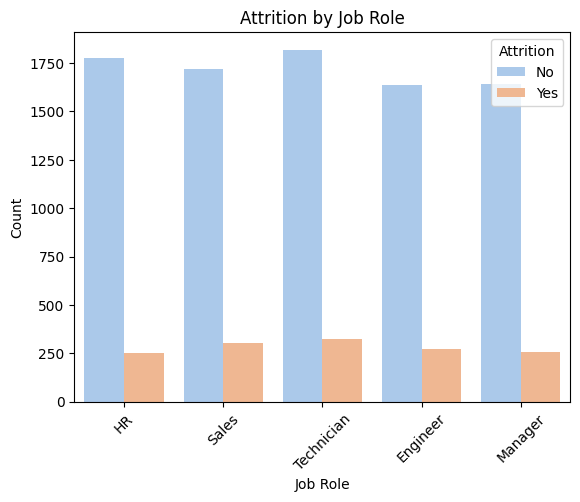

In [13]:
sns.countplot(x='Job Role', hue='Attrition', data=df, palette='pastel')
plt.title('Attrition by Job Role')
plt.xlabel('Job Role')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

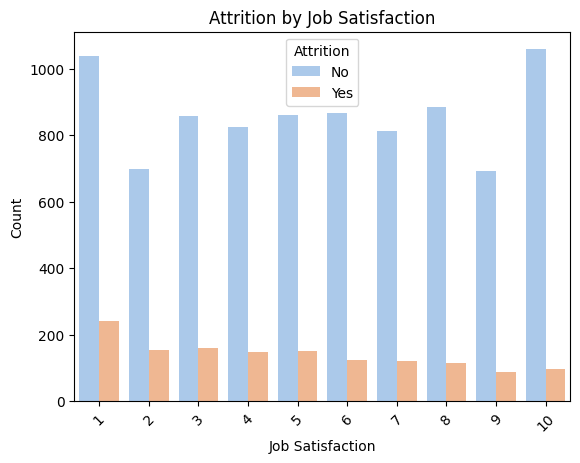

In [14]:
sns.countplot(x='Job Satisfaction', hue='Attrition', data=df, palette='pastel')
plt.title('Attrition by Job Satisfaction')
plt.xlabel('Job Satisfaction')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

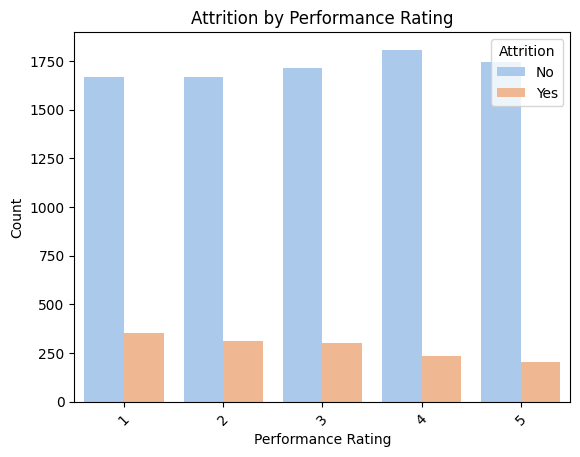

In [15]:
sns.countplot(x='Performance Rating', hue='Attrition', data=df, palette='pastel')
plt.title('Attrition by Performance Rating')
plt.xlabel('Performance Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [16]:
df['raise_amount'] = df['Monthly Income'] - (df['Monthly Income']/((df['Last Raise Percentage']/100)+1))

In [17]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.head()


,Employee ID,Age,Gender,Job Role,Department,Monthly Income,Years at Company,Number of Promotions,Last Raise Percentage,Distance from Office,Job Satisfaction,Performance Rating,Attrition,years_at_comp_bins,age_bins,raise_amount
0,1,50,Male,HR,IT,11547,12,1,12.29,41.31,9,1,No,7-13,50+,1263.69
1,2,36,Male,Sales,Support,8643,28,4,3.50,44.73,8,1,Yes,22+,31-40,291.98
2,3,29,Male,Technician,HR,12418,12,4,4.80,18.65,1,3,No,7-13,0-30,568.42
3,4,42,Male,Technician,Support,11441,25,1,10.31,15.79,8,4,No,22+,41-49,1069.36
4,5,40,Female,Engineer,Sales,9178,25,2,6.21,41.24,6,4,No,22+,31-40,536.64


In [18]:
# Convert 'Yes' to 1 and 'No' to 0
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

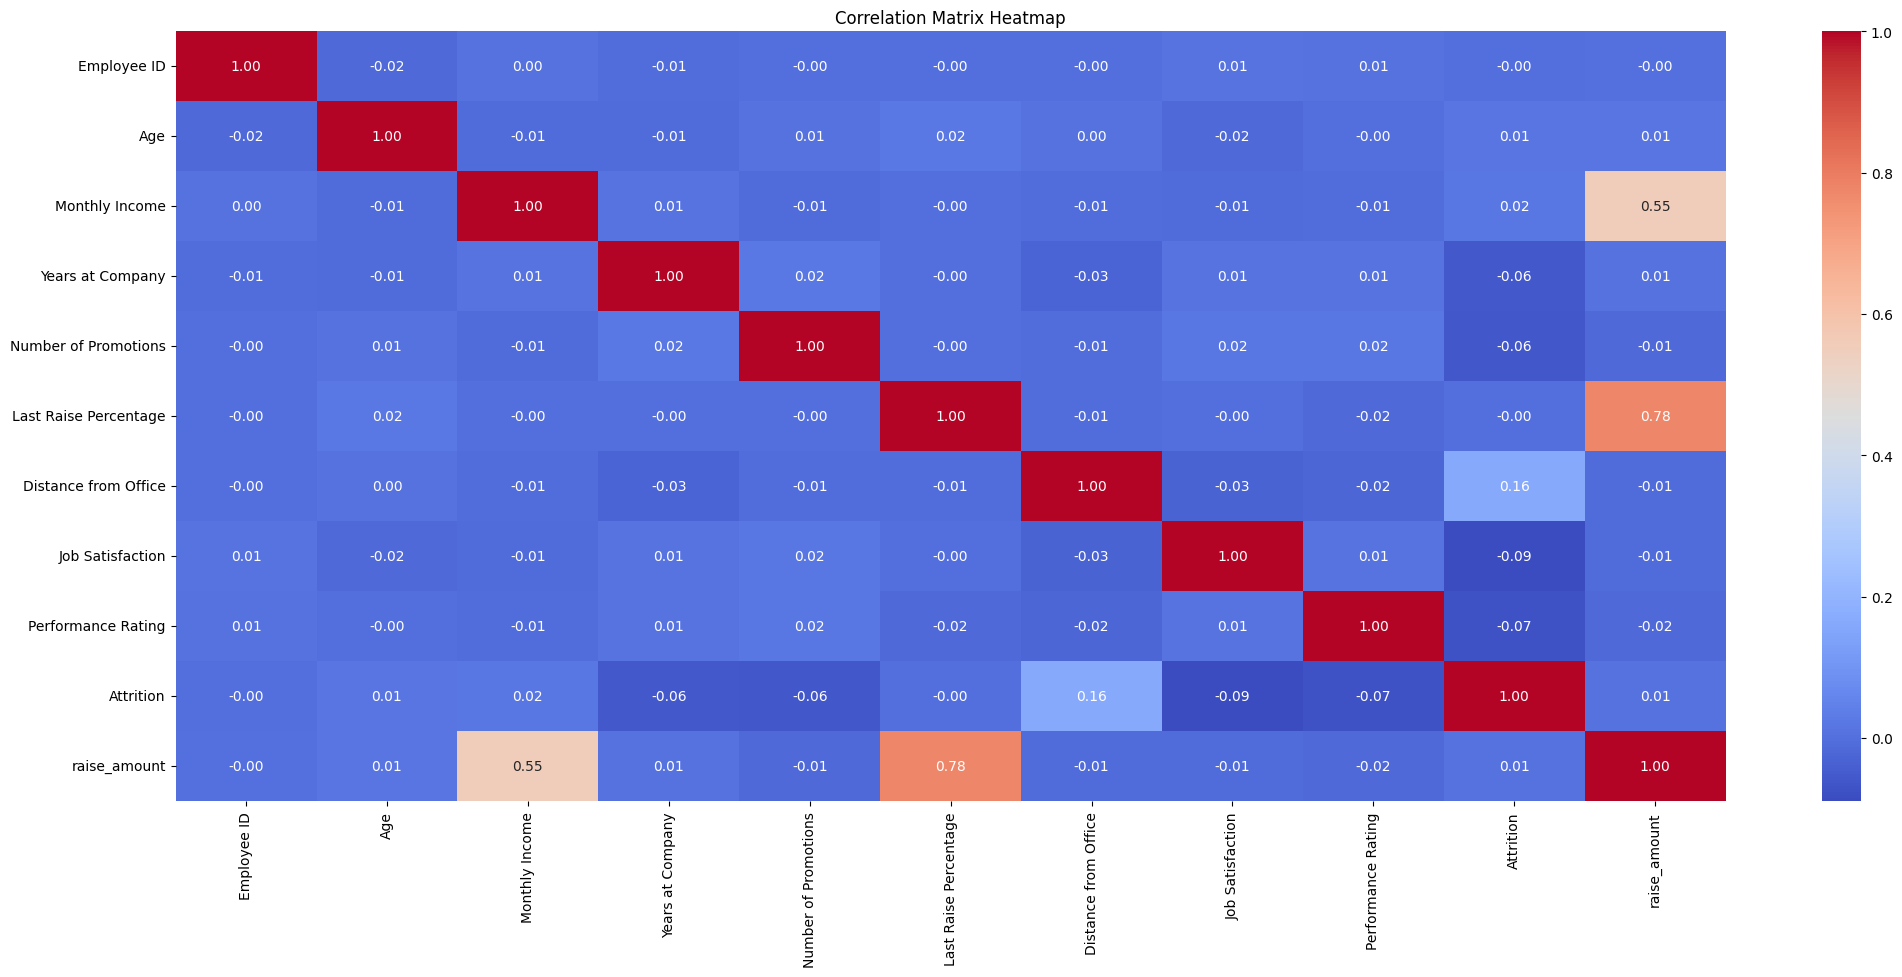

In [19]:
# heatmap of correlation matrix
plt.figure(figsize=(25, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [20]:
df.columns

Index(['Employee ID', 'Age', 'Gender', 'Job Role', 'Department',
       'Monthly Income', 'Years at Company', 'Number of Promotions',
       'Last Raise Percentage', 'Distance from Office', 'Job Satisfaction',
       'Performance Rating', 'Attrition', 'years_at_comp_bins', 'age_bins',
       'raise_amount'],
      dtype='object')

In [21]:
# Split Data for Model

X = df[['Gender', 'Job Role', 'Department','raise_amount',
       'Monthly Income', 'Number of Promotions',
       'Last Raise Percentage', 'Distance from Office', 'Job Satisfaction',
       'Performance Rating', 'years_at_comp_bins', 'age_bins']]
y = df['Attrition']

numeric_columns = ['Monthly Income','Number of Promotions','Last Raise Percentage','Distance from Office','raise_amount']
categorical_columns = ['Performance Rating','Job Satisfaction','Department','Job Role','age_bins','Gender','years_at_comp_bins']

In [22]:
# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [23]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore',sparse_output=False),categorical_columns)
    ]
)

In [24]:
# List of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# Evaluate each model using cross-validation
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=3,n_jobs=-1)
    print(f"{name} F1 Scores (weighted): {scores.mean():.3f} ± {scores.std():.3f}")

Logistic Regression F1 Scores (weighted): 0.792 ± 0.001


KeyboardInterrupt: 

In [ ]:
# Define the Logistic Regression model
logreg = LogisticRegression(max_iter=5000)

# Create the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logreg)
])

# Fit the model to the training data
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.86      1.00      0.93      2585
         Yes       0.00      0.00      0.00       415

    accuracy                           0.86      3000
   macro avg       0.43      0.50      0.46      3000
weighted avg       0.74      0.86      0.80      3000



C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

              precision    recall  f1-score   support

          No       0.87      1.00      0.93      2605
         Yes       0.54      0.03      0.06       395

    accuracy                           0.87      3000
   macro avg       0.71      0.51      0.50      3000
weighted avg       0.83      0.87      0.82      3000



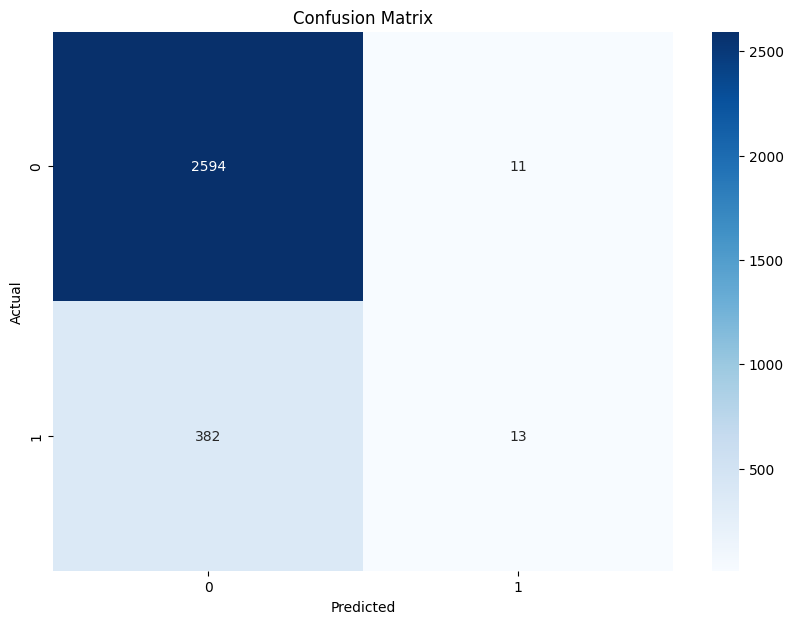

In [ ]:
# Define the preprocessor with OneHotEncoder for categorical features and MinMaxScaler for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create a pipeline with the preprocessor and a RandomForestClassifier
pipeline_rforest_rev = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100))
])

# Train the model
pipeline_rforest_rev.fit(X_train, y_train)

# Make predictions
y_pred = pipeline_rforest_rev.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

          No       0.86      0.98      0.92      2550
         Yes       0.51      0.11      0.18       450

    accuracy                           0.85      3000
   macro avg       0.69      0.55      0.55      3000
weighted avg       0.81      0.85      0.81      3000



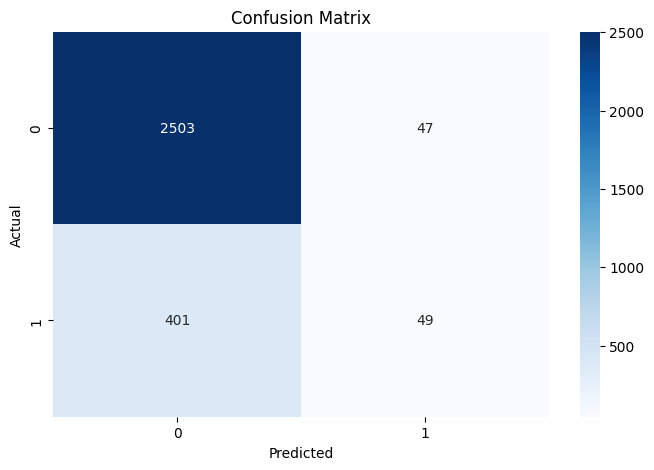

In [ ]:
# KNN
KNN = KNeighborsClassifier()

# Create the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNN)
])

# Fit the model to the training data
pipeline.fit(X_train, y_train)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define the parameter grid for KNN
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create a pipeline with the preprocessor and KNeighborsClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Assumes preprocessor is defined and configured
    ('classifier', KNeighborsClassifier())
])

# Set up the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Train the model with grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# Use the best estimator to predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best parameters found:  {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 11, 'classifier__weights': 'uniform'}
Best cross-validation accuracy: 0.86
              precision    recall  f1-score   support

          No       0.85      1.00      0.92      2550
         Yes       0.14      0.00      0.00       450

    accuracy                           0.85      3000
   macro avg       0.50      0.50      0.46      3000
weighted avg       0.74      0.85      0.78      3000

[[2544    6]
 [ 449    1]]


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [0.82085714 0.81714286 0.84471429 0.84185714 0.856      0.85414286
 0.85942857 0.85757143 0.862      0.86085714        nan 0.82071429
        nan 0.84157143        nan 0.85342857        nan 0.85685714
        nan 0.86028571 0.82085714 0.81714286 0.84471429 0.84185714
 0.856      0.85414286 0.85942857 0.85757143 0.862      0.86085714]
  warnings.warn(


              precision    recall  f1-score   support

          No       0.85      1.00      0.92      2550
         Yes       0.14      0.00      0.00       450

    accuracy                           0.85      3000
   macro avg       0.50      0.50      0.46      3000
weighted avg       0.74      0.85      0.78      3000



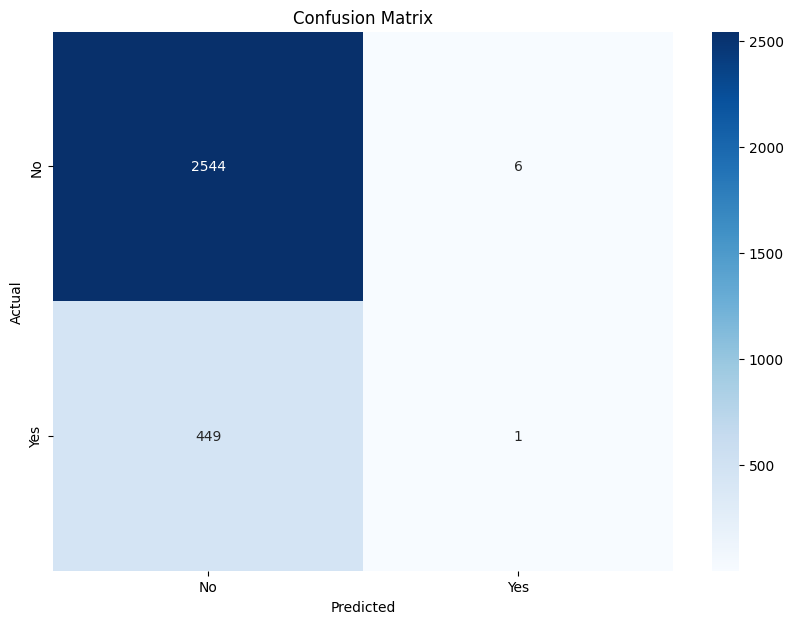

In [ ]:
# Define the best parameters
best_params = {
    'classifier__metric': 'euclidean',
    'classifier__n_neighbors': 11,
    'classifier__weights': 'uniform'
}

# Create a pipeline with the preprocessor and the best KNeighborsClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Assumes preprocessor is defined and configured
    ('classifier', KNeighborsClassifier(metric=best_params['classifier__metric'],
                                        n_neighbors=best_params['classifier__n_neighbors'],
                                        weights=best_params['classifier__weights']))
])

# Fit the model with the best parameters on the entire training set
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['No', 'Yes'])

# Create a heatmap plot of the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Assuming df is the DataFrame and preprocessed features and target are ready
X = df[['Age', 'Monthly Income', 'Years at Company', 'Number of Promotions', 'Last Raise Percentage', 'Distance from Office']]
y = df['Attrition']  # Attrition as 1 (Yes) and 0 (No)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importance
importance = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
print(feature_importance)

# Predict attrition risk scores
y_scores = model.predict_proba(X_test)[:, 1]
risk_scores = pd.DataFrame({'Employee ID': df['Employee ID'][X_test.index], 'Attrition Risk Score': y_scores})
print(risk_scores.head())

              precision    recall  f1-score   support

          No       0.91      0.58      0.71      1724
         Yes       0.19      0.62      0.29       276

    accuracy                           0.59      2000
   macro avg       0.55      0.60      0.50      2000
weighted avg       0.81      0.59      0.65      2000

                 Feature  Importance
0                    Age       -0.00
1         Monthly Income        0.00
2       Years at Company       -0.02
3   Number of Promotions       -0.13
4  Last Raise Percentage       -0.01
5   Distance from Office        0.03
      Employee ID  Attrition Risk Score
6252         6253                  0.35
4684         4685                  0.45
1731         1732                  0.55
4742         4743                  0.60
4521         4522                  0.30


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


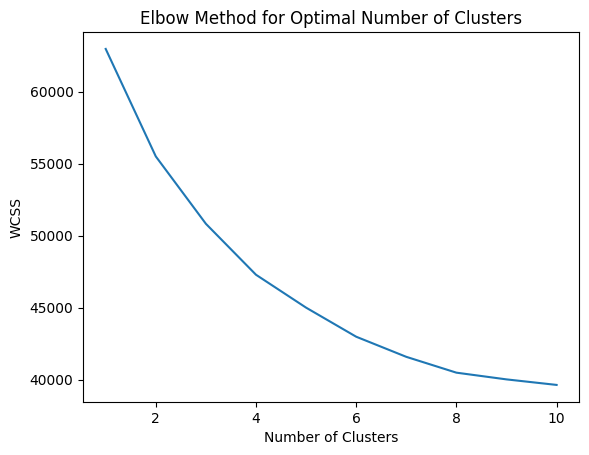

Cluster
0   0.17
1   0.08
2   0.18
3   0.14
Name: Attrition, dtype: float64
Cluster 0:
       Employee ID     Age  Monthly Income  Years at Company  \
count      2399.00 2399.00         2399.00           2399.00   
mean       4910.94   46.27         9021.04             21.71   
std        2900.26    8.45         3419.78              5.12   
min           1.00   22.00         3003.00              8.00   
25%        2414.50   40.00         6103.50             18.00   
50%        4799.00   47.00         9072.00             22.00   
75%        7449.00   53.00        11888.00             26.00   
max        9999.00   59.00        14991.00             30.00   

       Number of Promotions  Last Raise Percentage  Distance from Office  \
count               2399.00                2399.00               2399.00   
mean                   1.97                   9.89                 37.30   
std                    1.43                   5.81                  8.86   
min                    0.00     

In [ ]:
# Convert 'Attrition' to numeric
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Select relevant features
features = ['Age', 'Job Role', 'Department', 'Job Satisfaction', 'Performance Rating', 'Years at Company', 'Distance from Office']
df_selected = df[features]

# Preprocess data: encode categorical variables and scale numeric data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'Years at Company', 'Distance from Office']),
        ('cat', OneHotEncoder(), ['Job Role', 'Department', 'Job Satisfaction', 'Performance Rating'])
    ]
)

# Apply preprocessing
df_preprocessed = preprocessor.fit_transform(df_selected)

# Determine the number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_preprocessed)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Assuming optimal number of clusters is determined to be k
k = 4  # for example, based on the Elbow Method or silhouette analysis
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_preprocessed)

# Calculate attrition rates per cluster
attrition_rate = df.groupby('Cluster')['Attrition'].mean()

# Display clusters with higher attrition rates
print(attrition_rate)

# Profile clusters
for cluster in range(k):
    print(f"Cluster {cluster}:")
    print(df[df['Cluster'] == cluster].describe())

In [ ]:
X = df[['Gender', 'Job Role', 'Department','raise_amount',
       'Monthly Income', 'Number of Promotions',
       'Last Raise Percentage', 'Distance from Office', 'Job Satisfaction',
       'Attrition', 'years_at_comp_bins', 'age_bins']]
y = df['Performance Rating']

numeric_columns = ['Monthly Income','Number of Promotions','Last Raise Percentage','Distance from Office','raise_amount']
categorical_columns = ['Attrition','Job Satisfaction','Department','Job Role','age_bins','Gender','years_at_comp_bins']

In [ ]:
# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore',sparse_output=False),categorical_columns)
    ]
)

# List of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Evaluate each model using cross-validation
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=3,n_jobs=-1)
    print(f"{name} F1 Scores (weighted): {scores.mean():.3f} ± {scores.std():.3f}")



Logistic Regression F1 Scores (weighted): 0.205 ± 0.003
KNN F1 Scores (weighted): 0.189 ± 0.002
Naive Bayes F1 Scores (weighted): 0.201 ± 0.004
Decision Tree F1 Scores (weighted): 0.193 ± 0.009
Random Forest F1 Scores (weighted): 0.199 ± 0.009


              precision    recall  f1-score   support

           1       0.19      0.25      0.22       570
           2       0.19      0.17      0.18       594
           3       0.20      0.15      0.17       665
           4       0.20      0.23      0.21       588
           5       0.18      0.17      0.17       583

    accuracy                           0.19      3000
   macro avg       0.19      0.19      0.19      3000
weighted avg       0.19      0.19      0.19      3000



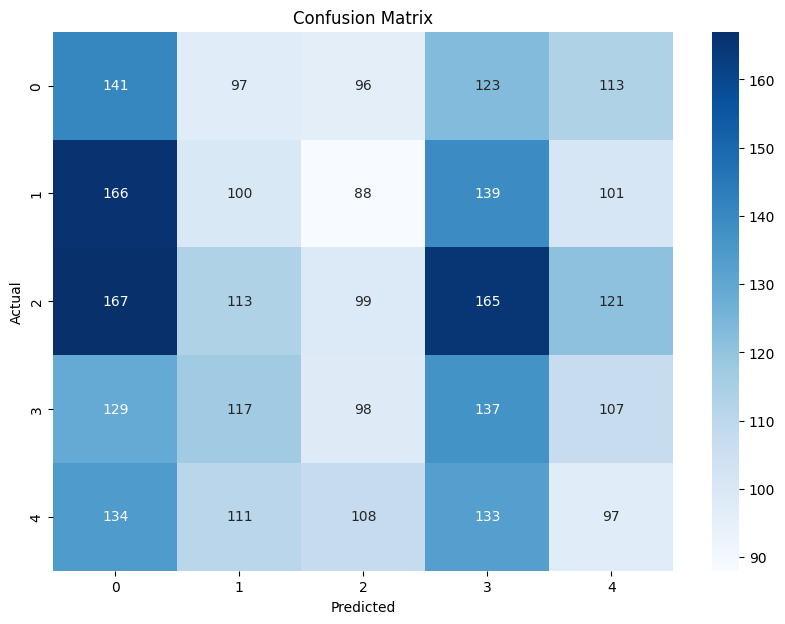

In [ ]:
# Random Forest

# Define the preprocessor with OneHotEncoder for categorical features and MinMaxScaler for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create a pipeline with the preprocessor and a RandomForestClassifier
pipeline_rforest_rev = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100))
])

# Train the model
pipeline_rforest_rev.fit(X_train, y_train)

# Make predictions
y_pred = pipeline_rforest_rev.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
df['Attrition'].value_counts()

Attrition
No     8597
Yes    1403
Name: count, dtype: int64